# A Dynamical View of RNNs, and How Dynamics Shape

## Imports

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath(".")), ""))
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
from src import ElmanRNN, Adam

from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams.update({"figure.dpi": 120, "font.size": 9})
cmap = plt.cm.tab10.colors

## Utils

In [2]:
def make_sequences(parametric_fn, n_seqs, seq_len, dt, rng):
    """Next-step prediction data from a parametric curve.

    parametric_fn(theta) -> (x_array, y_array)
    Returns x, y each of shape (seq_len, n_seqs, 2).
    """
    phases = rng.uniform(0, 2 * np.pi, n_seqs)
    t = np.arange(seq_len + 1) * dt
    trajs = []
    for phi in phases:
        theta = phi + t
        xy = np.column_stack(parametric_fn(theta))
        trajs.append(xy)
    data = np.stack(trajs, axis=1)
    return data[:-1].copy(), data[1:].copy()


# Parametric curves
def circle_curve(theta, r=1.0, cx=0.0, cy=0.0):
    return r * np.cos(theta) + cx, r * np.sin(theta) + cy

def figure8_curve(theta):
    return np.sin(theta), np.sin(theta) * np.cos(theta)

def ellipse_curve(theta, a=3.0, b=1.0, cx=0.0, cy=0.0):
    return a * np.cos(theta) + cx, b * np.sin(theta) + cy


def train(model, opt, x, y, batch_indices, n_epochs, print_every=500):
    losses = []
    for ep in range(1, n_epochs + 1):
        result = model.forward(x, y, batch_indices=batch_indices)
        grads, dH0 = model.backward(result.cache)
        model.params, new_H0, gnorm = opt.step(
            model.params, grads, dH0, model.H0_params, batch_indices
        )
        if new_H0 is not None:
            model.H0_params = new_H0
        losses.append(result.loss)
        if ep % print_every == 0 or ep == 1:
            print(f"  epoch {ep:5d}  loss {result.loss:.6f}  |g| {gnorm:.4f}")
    return losses


def generate(model, x0, n_steps, seq_idx=0):
    """Rollout from x0 using learned H0[seq_idx]."""
    x_t = x0.reshape(1, 1, -1)
    if model.H0_params is not None:
        h = model.H0_params[seq_idx : seq_idx + 1].copy()
    else:
        h = np.zeros((1, model.params.hidden_size), dtype=np.float64)
    traj = [x0.copy()]
    hs = [h[0].copy()]
    for _ in range(n_steps):
        res = model.forward(x_t, h0=h)
        x_t = res.out.copy()
        h = res.h_last
        traj.append(res.out[0, 0].copy())
        hs.append(h[0].copy())
    return np.array(traj), np.array(hs)


def plot_with_arrows(ax, trajs, title="", every=3, labels=None):
    """2-D trajectories with quiver arrows showing direction."""
    for i, traj in enumerate(trajs):
        c = cmap[i % 10]
        lbl = labels[i] if labels else None
        ax.plot(traj[:, 0], traj[:, 1], "-", color=c, lw=1.2, alpha=0.7, label=lbl)
        idx = np.arange(0, len(traj) - 1, every)
        dx = traj[idx + 1, 0] - traj[idx, 0]
        dy = traj[idx + 1, 1] - traj[idx, 1]
        ax.quiver(
            traj[idx, 0], traj[idx, 1], dx, dy,
            color=c, angles="xy", scale_units="xy", scale=1,
            width=0.006, headwidth=3.5, zorder=3,
        )
    ax.set_title(title)
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)
    if labels:
        ax.legend(fontsize=8)

def plot_with_arrows_3d(ax, trajs, title="", every=3, labels=None):
    cmap = plt.get_cmap("tab10")
    
    for i, traj in enumerate(trajs):
        c = cmap(i % 10)
        lbl = labels[i] if labels else None
        
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=c, lw=1.2, alpha=0.7, label=lbl)
        
        idx = np.arange(0, len(traj) - 1, every)
        x, y, z = traj[idx, 0], traj[idx, 1], traj[idx, 2]
        u = traj[idx + 1, 0] - x
        v = traj[idx + 1, 1] - y
        w = traj[idx + 1, 2] - z
        
        ax.quiver(x, y, z, u, v, w, color=c, length=1.0, normalize=False, 
                  arrow_length_ratio=0.3, pivot='tail')

    ax.set_title(title)
    if labels:
        ax.legend(fontsize=8)

## Hyperparams for the entire analysis

In [3]:
rng = np.random.default_rng(42)

T, B = 30, 16
dt = 2 * np.pi / 30

## Experiment 1 — Circle

16 training sequences of 30 steps each, **random starting phases** so the
network is forced to learn the rotational dynamics rather than memorise one
particular initial condition.

Let's start with a single circle:

### Single Circle

  epoch     1  loss 0.505703  |g| 0.1419
  epoch   500  loss 0.006877  |g| 0.0156
  epoch  1000  loss 0.004412  |g| 0.0087
  epoch  1500  loss 0.002861  |g| 0.0067
  epoch  2000  loss 0.001538  |g| 0.0048
  epoch  2500  loss 0.000686  |g| 0.0030
  epoch  3000  loss 0.000306  |g| 0.0016


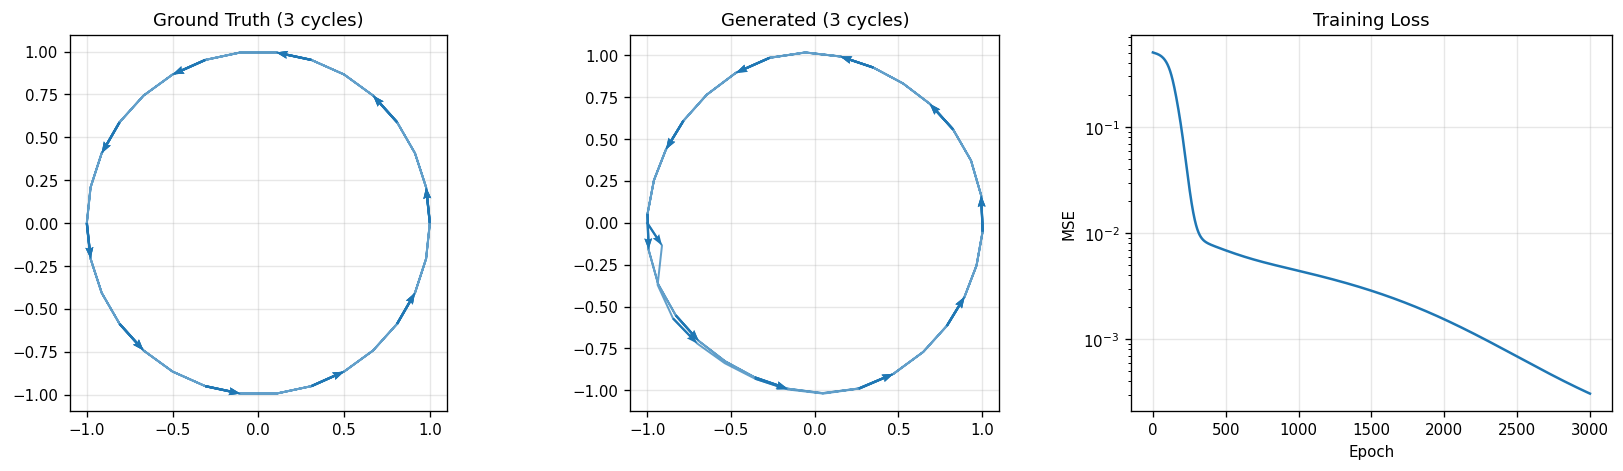

In [4]:
x_train, y_train = make_sequences(circle_curve, B, T, dt, rng)
batch_indices = np.zeros(B, dtype=np.int64)

model = ElmanRNN(2, 4, 2, num_sequences=1, activation="tanh",
                   weight_scale=0.1, rng=0)
opt = Adam(lr=1e-3, clip_norm=1.0)

losses = train(model, opt, x_train, y_train, batch_indices, n_epochs=3000)

pred, hs = generate(model, np.array([-1.0, 0.0]), n_steps=90)
gt_theta = np.linspace(0, 6 * np.pi, 91)
gt = np.column_stack([np.cos(gt_theta), np.sin(gt_theta)])

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt], title="Ground Truth (3 cycles)")
plot_with_arrows(axes[1], [pred], title="Generated (3 cycles)")
axes[2].semilogy(losses)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

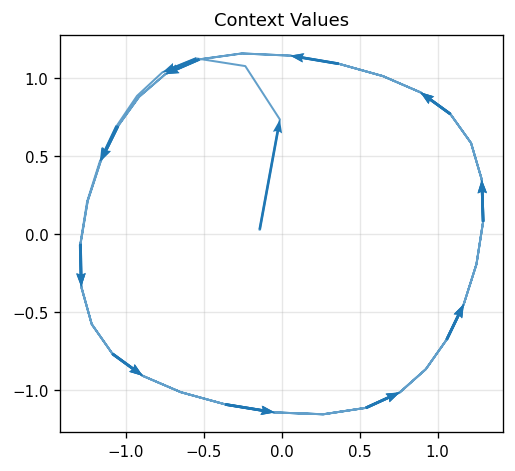

In [5]:
pca = PCA(n_components=2)
hs_pca = pca.fit_transform(hs)

fig, ax = plt.subplots(figsize=(14, 4))
plot_with_arrows(ax, [hs_pca], title="Context Values")
plt.tight_layout()
plt.show()

Now let's check what happens if we have starting points that are not on the curve!

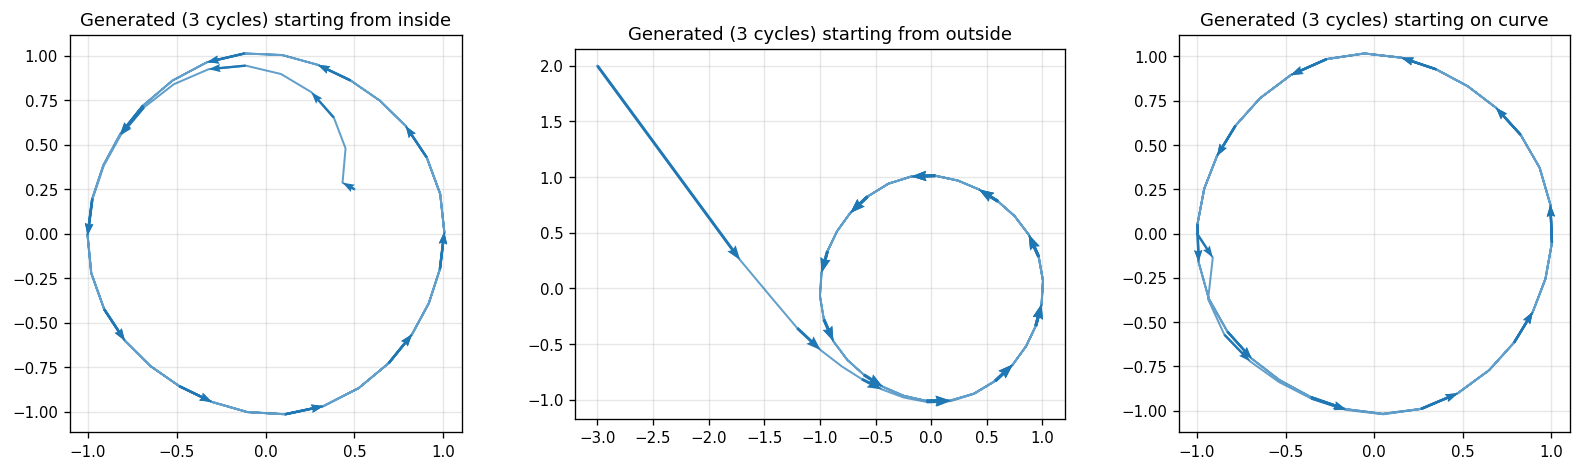

In [6]:
pred_in, hs_in = generate(model, np.array([0.5, 0.25]), n_steps=90)
pred_out, hs_out = generate(model, np.array([-3, 2.0]), n_steps=90)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [pred_in], title="Generated (3 cycles) starting from inside")
plot_with_arrows(axes[1], [pred_out], title="Generated (3 cycles) starting from outside")
plot_with_arrows(axes[2], [pred], title="Generated (3 cycles) starting on curve")
plt.tight_layout()
plt.show()

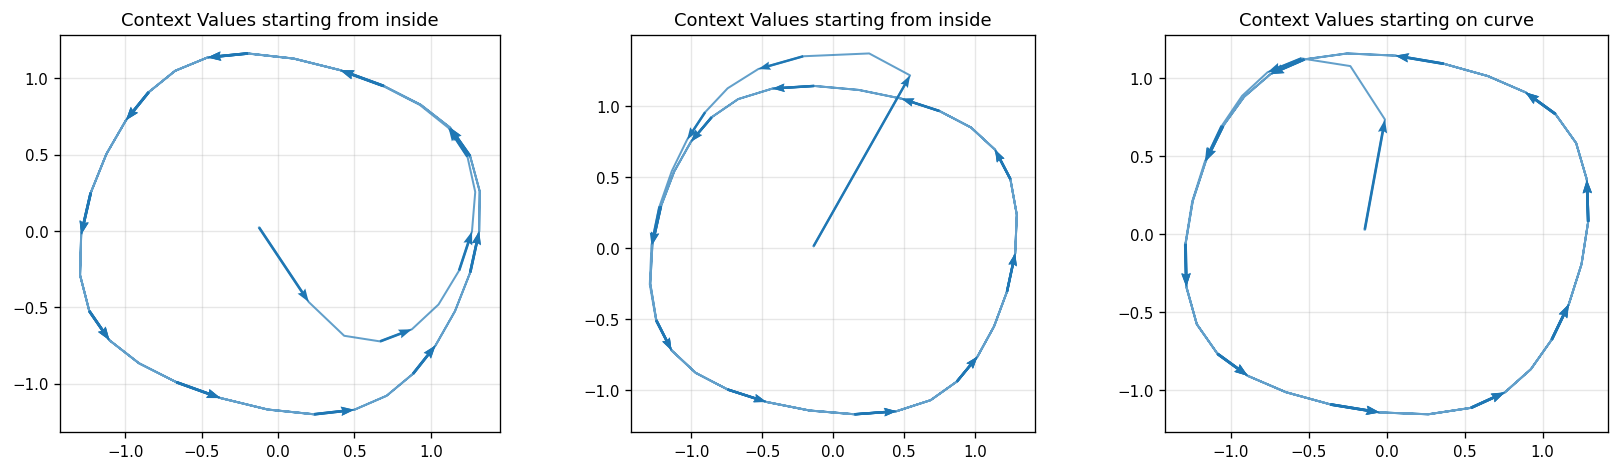

In [7]:
hs_in_pca = pca.fit_transform(hs_in)
hs_out_pca = pca.fit_transform(hs_out)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [hs_in_pca], title="Context Values starting from inside")
plot_with_arrows(axes[1], [hs_out_pca], title="Context Values starting from inside")
plot_with_arrows(axes[2], [hs_pca], title="Context Values starting on curve")
plt.tight_layout()
plt.show()

### Multiple Circles

Given that with one circle, all points eventually converge to the circle, let's see what happens if we have multiple circles with non-overlapping points!

  epoch     1  loss 2.402530  |g| 2.9443
  epoch   500  loss 0.004153  |g| 0.0185
  epoch  1000  loss 0.000276  |g| 0.0034
  epoch  1500  loss 0.000062  |g| 0.0006
  epoch  2000  loss 0.000034  |g| 0.0003
  epoch  2500  loss 0.000022  |g| 0.0033
  epoch  3000  loss 0.000015  |g| 0.0001


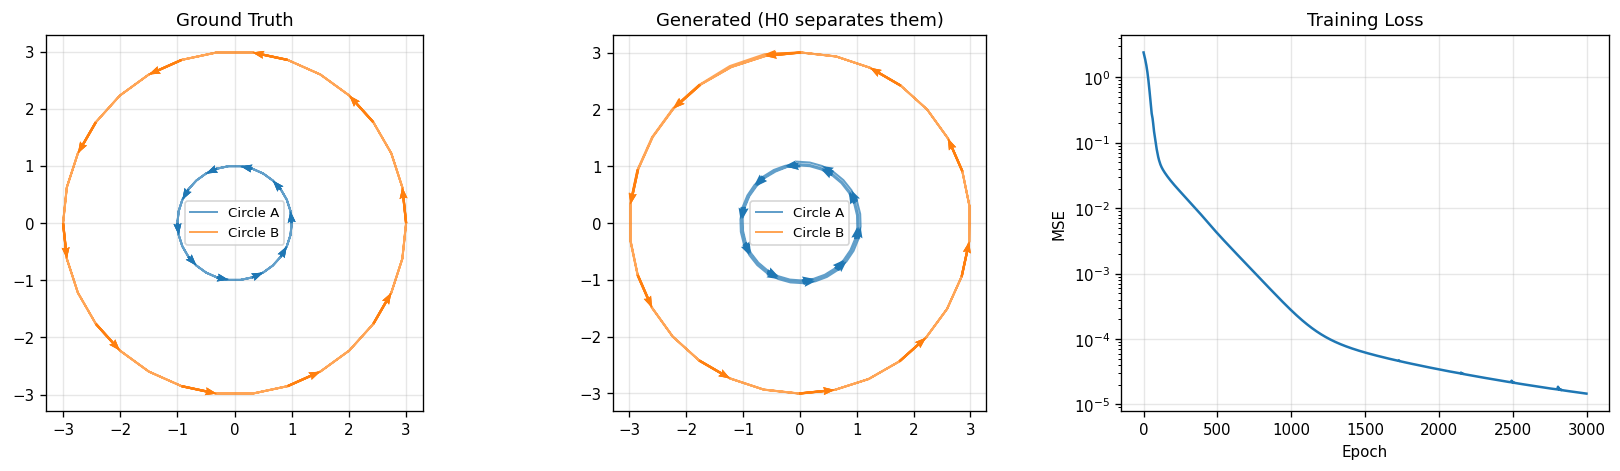

In [8]:
fn_a = lambda th: circle_curve(th, r=1.0, cx=0.0, cy=0.0)
fn_b = lambda th: circle_curve(th, r=3.0, cx=-0.0, cy=0.0)

xa, ya = make_sequences(fn_a, B, T, dt, rng)
xb, yb = make_sequences(fn_b, B, T, dt, rng)

x_train = np.concatenate([xa, xb], axis=1)
y_train = np.concatenate([ya, yb], axis=1)
batch_indices = np.array([0] * B + [1] * B, dtype=np.int64)

model = ElmanRNN(2, 32, 2, num_sequences=2, activation="tanh",
                   weight_scale=0.1, rng=2)
opt = Adam(lr=1e-3, clip_norm=1.0)

losses = train(model, opt, x_train, y_train, batch_indices, n_epochs=3000)

# Generate 3 cycles for each circle
pred_a, hs_a = generate(model, np.array([0.0, 1.0]), n_steps=90, seq_idx=0)
pred_b, hs_b = generate(model, np.array([0.0, 3.0]), n_steps=90, seq_idx=1)

gt_theta = np.linspace(0, 6 * np.pi, 91)
gt_a = np.column_stack([np.cos(gt_theta), np.sin(gt_theta)])
gt_b = np.column_stack([3 * np.cos(gt_theta), 3 * np.sin(gt_theta)])

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt_a, gt_b], title="Ground Truth",
                 labels=["Circle A", "Circle B"])
plot_with_arrows(axes[1], [pred_a, pred_b], title="Generated (H0 separates them)",
                 labels=["Circle A", "Circle B"])
axes[2].semilogy(losses)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

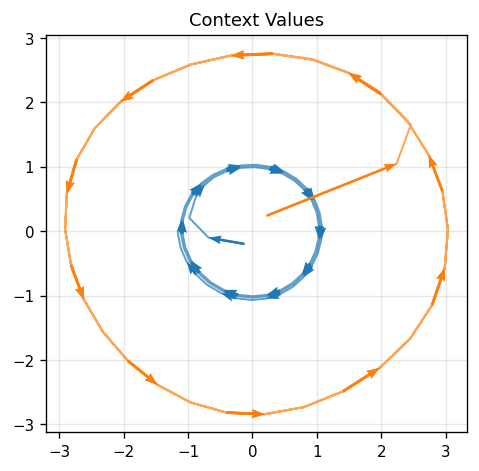

In [9]:
hs_a_pca = pca.fit_transform(hs_a)
hs_b_pca = pca.fit_transform(hs_b)

fig, ax = plt.subplots(figsize=(14, 4))
plot_with_arrows(ax, [hs_a_pca, hs_b_pca], title="Context Values")
plt.tight_layout()
plt.show()

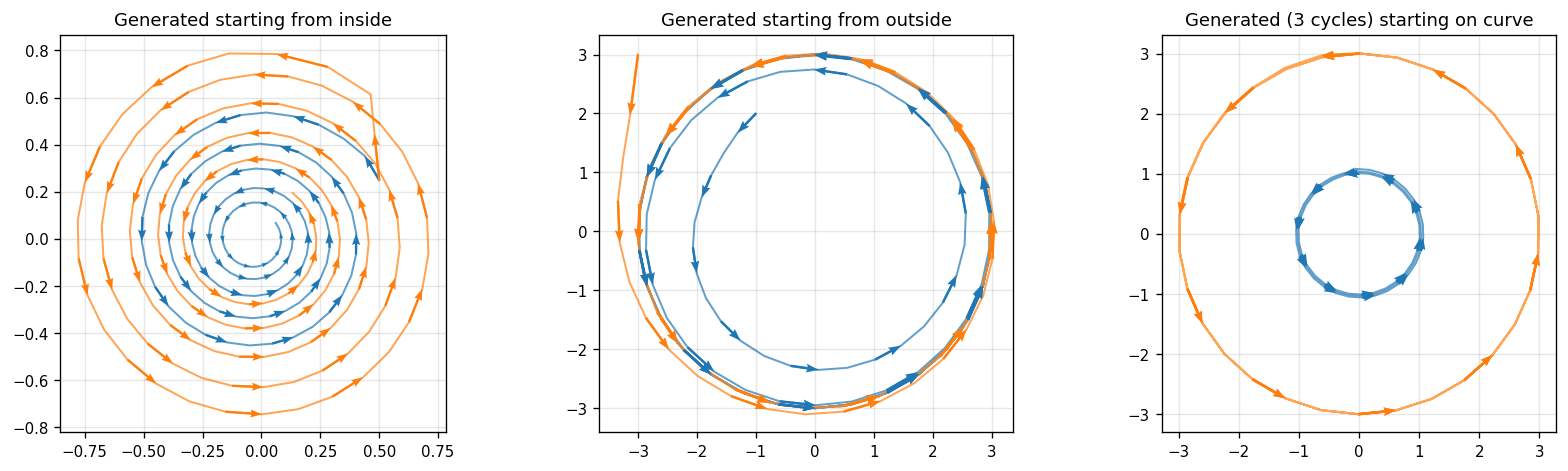

In [10]:
pred_a_in, hs_a_in = generate(model, np.array([0.5, 0.25]), n_steps=150, seq_idx=0)
pred_a_out, hs_a_out = generate(model, np.array([-1, 2.0]), n_steps=150, seq_idx=0)

pred_b_in, hs_b_in = generate(model, np.array([0.5, 0.25]), n_steps=150, seq_idx=1)
pred_b_out, hs_b_out = generate(model, np.array([-3, 3.0]), n_steps=150, seq_idx=1)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [pred_a_in, pred_b_in], title="Generated starting from inside")
plot_with_arrows(axes[1], [pred_a_out, pred_b_out], title="Generated starting from outside")
plot_with_arrows(axes[2], [pred_a, pred_b], title="Generated (3 cycles) starting on curve")
plt.tight_layout()
plt.show()

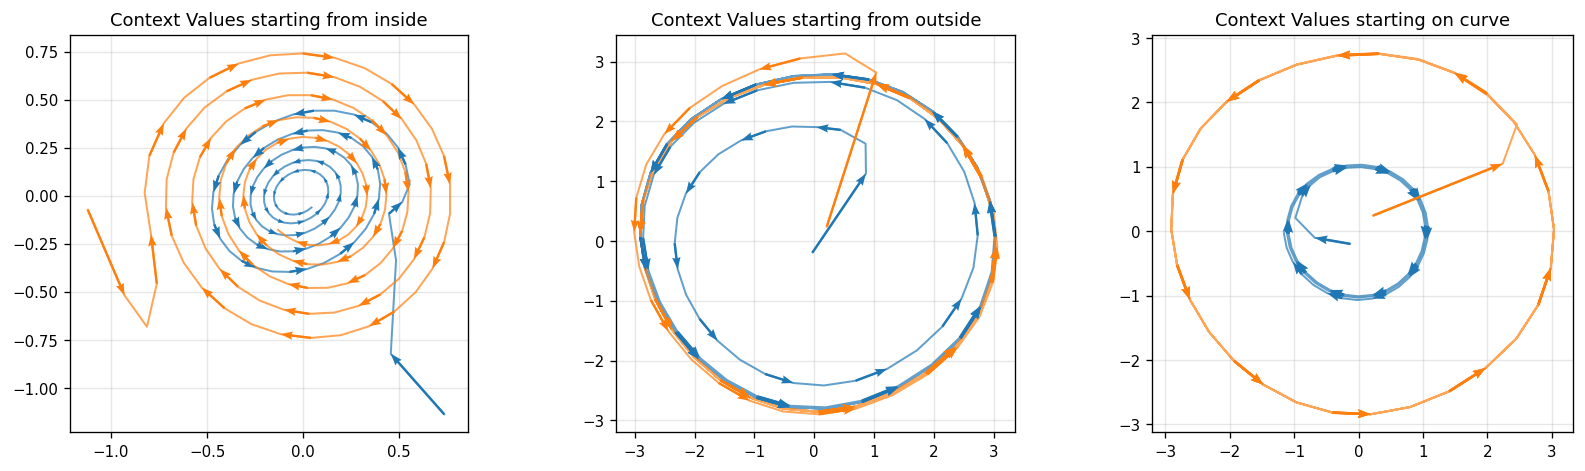

In [11]:
hs_a_in_pca = pca.fit_transform(hs_a_in)
hs_a_out_pca = pca.fit_transform(hs_a_out)

hs_b_in_pca = pca.fit_transform(hs_b_in)
hs_b_out_pca = pca.fit_transform(hs_b_out)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [hs_a_in_pca, hs_b_in_pca], title="Context Values starting from inside")
plot_with_arrows(axes[1], [hs_a_out_pca, hs_b_out_pca], title="Context Values starting from outside")
plot_with_arrows(axes[2], [hs_a_pca, hs_b_pca], title="Context Values starting on curve")
plt.tight_layout()
plt.show()

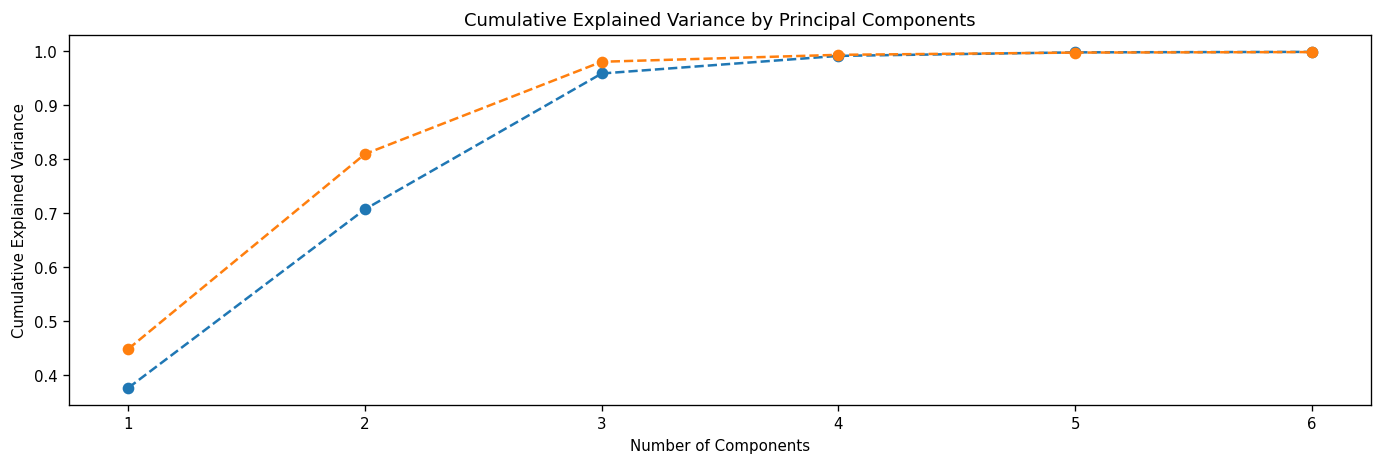

In [12]:
pca = PCA()

hs_a_in_pca = pca.fit(hs_a_in)
exp_var_a_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues_a = np.cumsum(exp_var_a_pca)

hs_b_in_pca = pca.fit(hs_b_in)
exp_var_b_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues_b = np.cumsum(exp_var_b_pca)

plt.figure(figsize=(14, 4))
plt.plot(range(1, len(cum_sum_eigenvalues_a[:6]) + 1), cum_sum_eigenvalues_a[:6], marker='o', linestyle='--', color=cmap[0])
plt.plot(range(1, len(cum_sum_eigenvalues_b[:6]) + 1), cum_sum_eigenvalues_b[:6], marker='o', linestyle='--', color=cmap[1])

plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

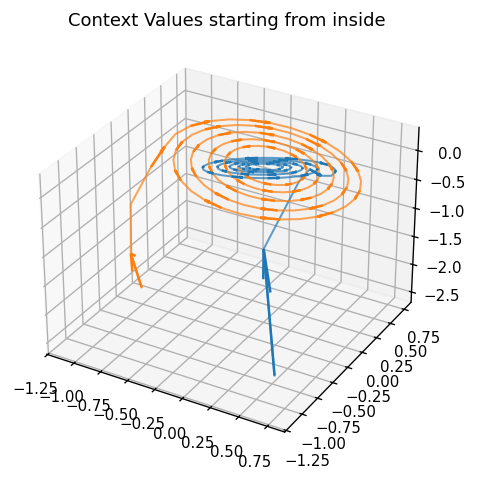

In [13]:
pca = PCA(n_components=3)

hs_a_in_pca = pca.fit_transform(hs_a_in)
hs_b_in_pca = pca.fit_transform(hs_b_in)

fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(111, projection='3d') 
plot_with_arrows_3d(ax, [hs_a_in_pca, hs_b_in_pca], title="Context Values starting from inside")
plt.tight_layout()
plt.show()

## Experiment 2 — Figure-of-8 (Lissajous)

$x = \sin\theta,\; y = \sin\theta\cos\theta$.  Same setup: 16 random-phase
sequences, next-step prediction.

  epoch     1  loss 0.383751  |g| 0.9490
  epoch   500  loss 0.002194  |g| 0.0054
  epoch  1000  loss 0.000946  |g| 0.0010
  epoch  1500  loss 0.000687  |g| 0.0006
  epoch  2000  loss 0.000518  |g| 0.0005
  epoch  2500  loss 0.000375  |g| 0.0004
  epoch  3000  loss 0.000255  |g| 0.0003
  epoch  3500  loss 0.000190  |g| 0.0002
  epoch  4000  loss 0.000167  |g| 0.0001


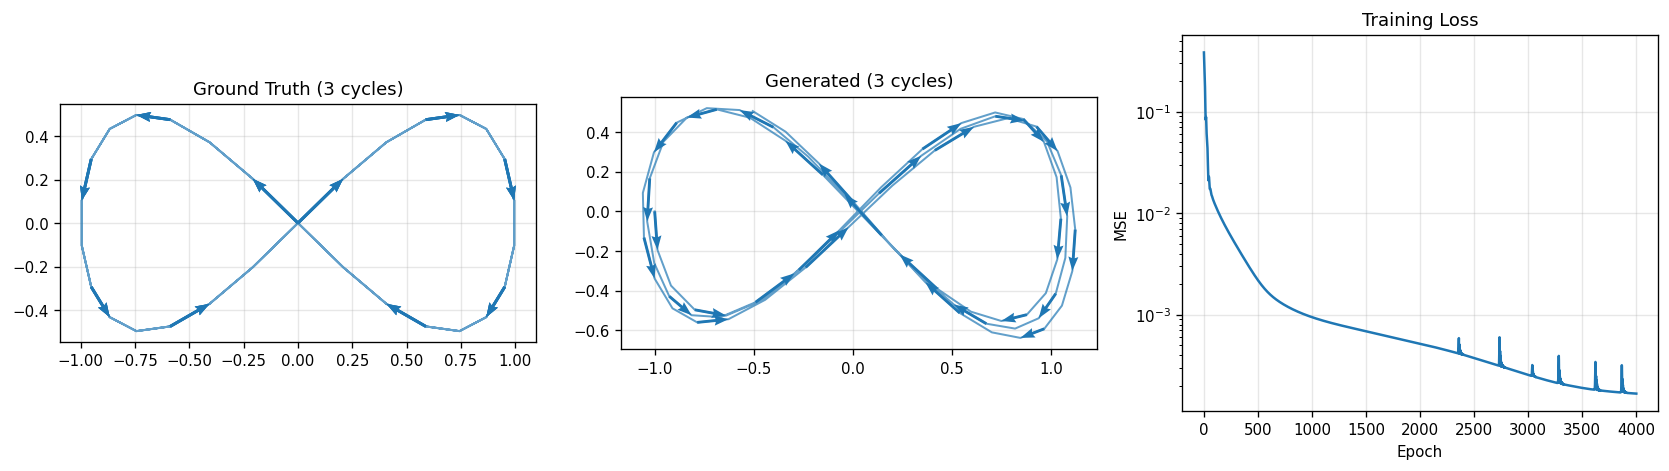

In [14]:
x_train, y_train = make_sequences(figure8_curve, B, T, dt, rng)
batch_indices = np.zeros(B, dtype=np.int64)

model = ElmanRNN(2, 64, 2, num_sequences=1, activation="tanh",
                   weight_scale=0.1, rng=1)
opt = Adam(lr=1e-3, clip_norm=1.0)


losses = train(model, opt, x_train, y_train, batch_indices, n_epochs=4000)

pred, hs = generate(model, np.array([-1.0, 0.0]), n_steps=90)
gt_theta = np.linspace(0, 6 * np.pi, 91)
gt = np.column_stack([np.sin(gt_theta), np.sin(gt_theta) * np.cos(gt_theta)])

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt], title="Ground Truth (3 cycles)")
plot_with_arrows(axes[1], [pred], title="Generated (3 cycles)")
axes[2].semilogy(losses)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

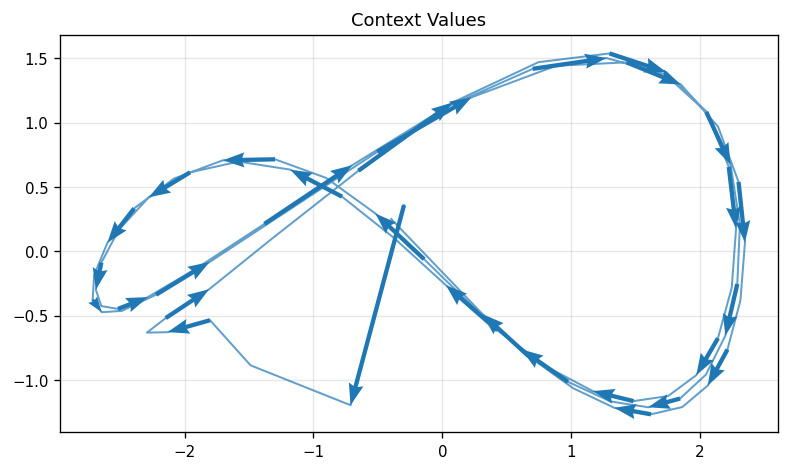

In [15]:
pca = PCA(n_components=2)
hs_pca = pca.fit_transform(hs)

fig, ax = plt.subplots(figsize=(14, 4))
plot_with_arrows(ax, [hs_pca], title="Context Values")
plt.tight_layout()
plt.show()

## Experiment 3 — Ellipse

Let's try the ellipse dynamics!

### Single Ellipse

  epoch     1  loss 2.551382  |g| 1.5792
  epoch   500  loss 0.097048  |g| 0.3589
  epoch  1000  loss 0.011924  |g| 0.0764
  epoch  1500  loss 0.004400  |g| 0.0205
  epoch  2000  loss 0.002612  |g| 0.0107
  epoch  2500  loss 0.001577  |g| 0.0066
  epoch  3000  loss 0.001014  |g| 0.0042
  epoch  3500  loss 0.000688  |g| 0.0028
  epoch  4000  loss 0.000479  |g| 0.0020


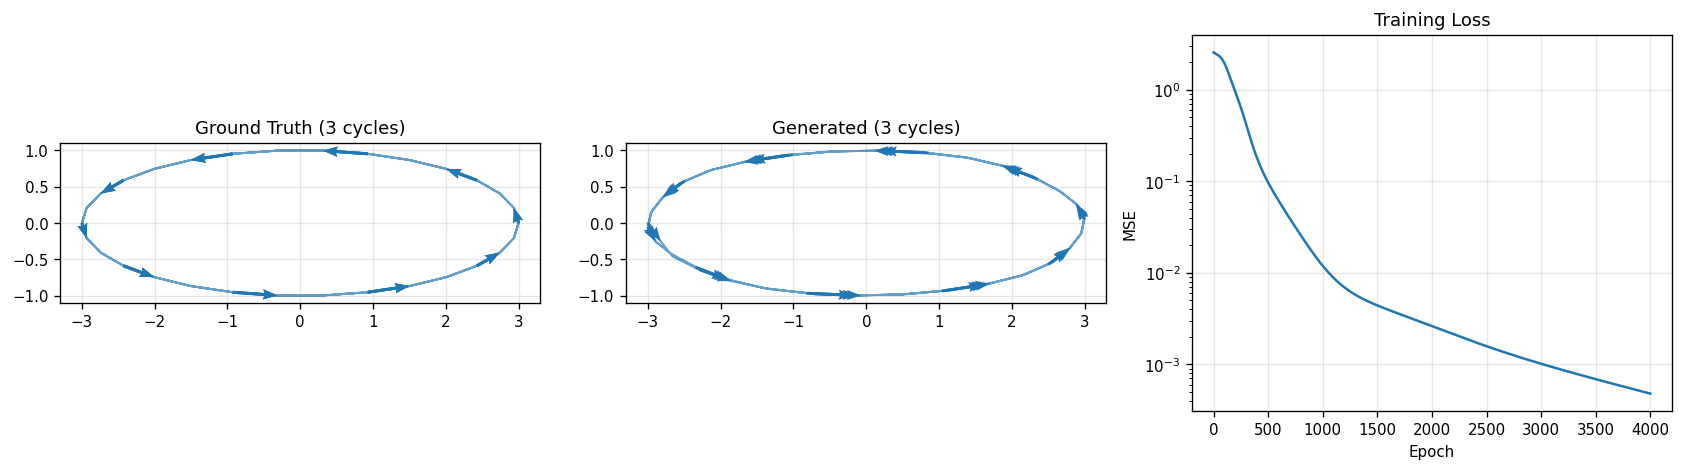

In [16]:
x_train, y_train = make_sequences(ellipse_curve, B, T, dt, rng)
batch_indices = np.zeros(B, dtype=np.int64)

model = ElmanRNN(2, 4, 2, num_sequences=1, activation="tanh",
                   weight_scale=0.1, rng=1)
opt = Adam(lr=1e-3, clip_norm=1.0)


losses = train(model, opt, x_train, y_train, batch_indices, n_epochs=4000)

pred, hs = generate(model, np.array([-3.0, 0.0]), n_steps=90)
gt_theta = np.linspace(0, 6 * np.pi, 91)
gt = np.column_stack([3 * np.cos(gt_theta), np.sin(gt_theta)])

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt], title="Ground Truth (3 cycles)")
plot_with_arrows(axes[1], [pred], title="Generated (3 cycles)")
axes[2].semilogy(losses)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

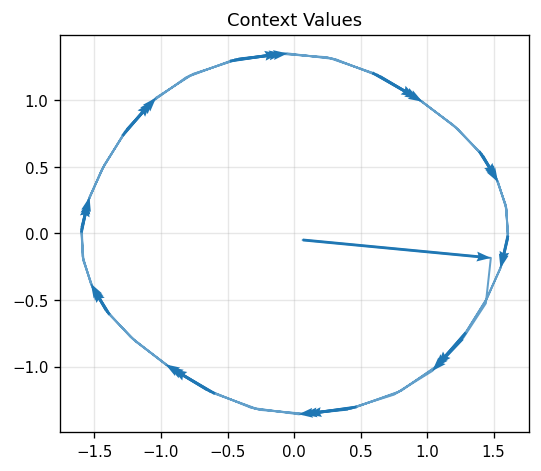

In [17]:
hs_pca = pca.fit_transform(hs)

fig, ax = plt.subplots(figsize=(14, 4))
plot_with_arrows(ax, [hs_pca], title="Context Values")
plt.tight_layout()
plt.show()

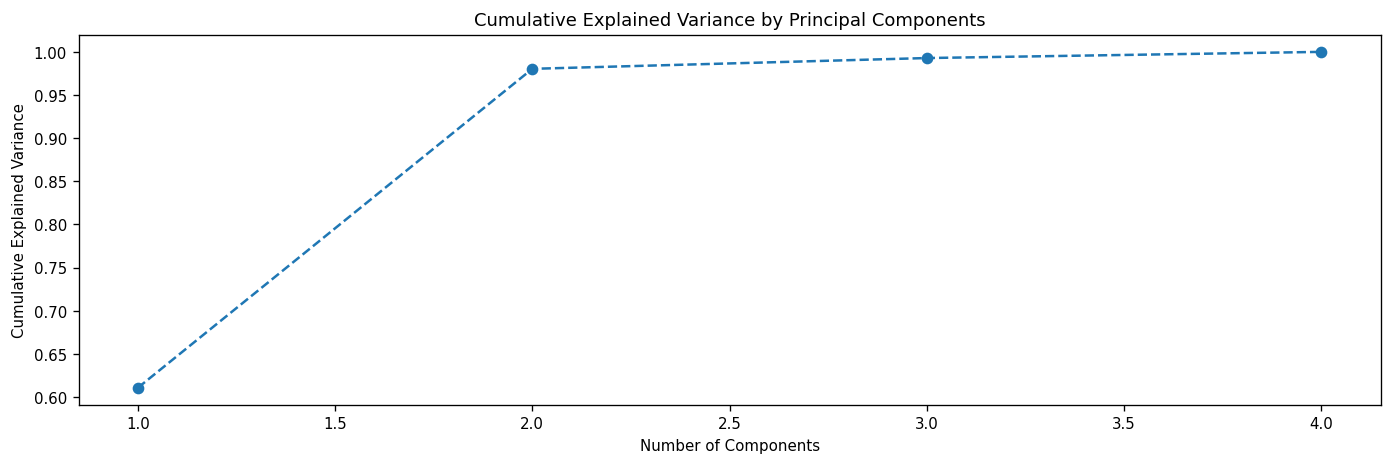

In [18]:
pca = PCA()

hs_pca = pca.fit(hs)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.figure(figsize=(14, 4))
plt.plot(range(1, len(cum_sum_eigenvalues[:6]) + 1), cum_sum_eigenvalues[:6], marker='o', linestyle='--', color=cmap[0])

plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Ellipse and Circle

  epoch     1  loss 2.065400  |g| 5.9031
  epoch   500  loss 0.001872  |g| 0.0059
  epoch  1000  loss 0.000338  |g| 0.0357
  epoch  1500  loss 0.000106  |g| 0.0008
  epoch  2000  loss 0.000049  |g| 0.0042
  epoch  2500  loss 0.000026  |g| 0.0002
  epoch  3000  loss 0.000017  |g| 0.0003


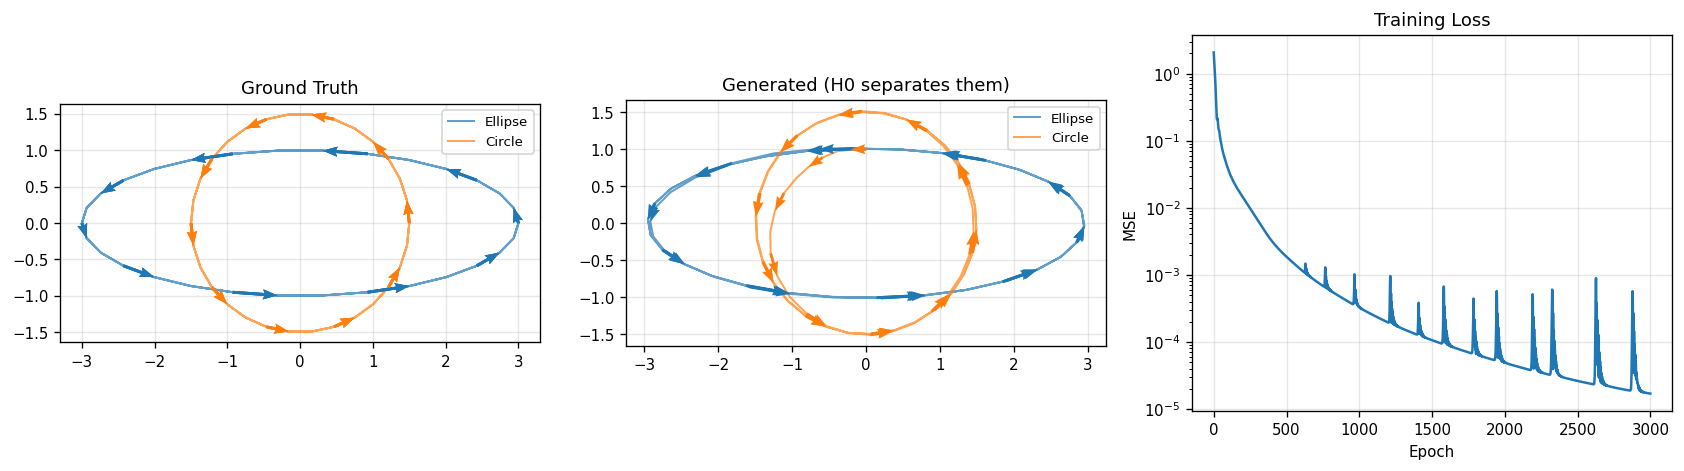

In [19]:
fn_b = lambda th: circle_curve(th, r=1.5, cx=0.0, cy=0.0)

xa, ya = make_sequences(ellipse_curve, B, T, dt, rng)
xb, yb = make_sequences(fn_b, B, T, dt, rng)

x_train = np.concatenate([xa, xb], axis=1)
y_train = np.concatenate([ya, yb], axis=1)
batch_indices = np.array([0] * B + [1] * B, dtype=np.int64)

model = ElmanRNN(2, 64, 2, num_sequences=2, activation="tanh",
                   weight_scale=0.1, rng=2)
opt = Adam(lr=1e-3, clip_norm=1.0)

losses = train(model, opt, x_train, y_train, batch_indices, n_epochs=3000)

# Generate 3 cycles for each circle
pred_a, hs_a = generate(model, np.array([0.0, 1.0]), n_steps=90, seq_idx=0)
pred_b, hs_b = generate(model, np.array([0.0, 1.0]), n_steps=90, seq_idx=1)

gt_theta = np.linspace(0, 6 * np.pi, 91)
gt_a = np.column_stack(ellipse_curve(gt_theta, a=3.0, b=1.0, cx=0.0, cy=0.0))
gt_b = np.column_stack(circle_curve(gt_theta, r=1.5, cx=0.0, cy=0.0))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt_a, gt_b], title="Ground Truth",
                 labels=["Ellipse", "Circle"])
plot_with_arrows(axes[1], [pred_a, pred_b], title="Generated (H0 separates them)",
                 labels=["Ellipse", "Circle"])
axes[2].semilogy(losses)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

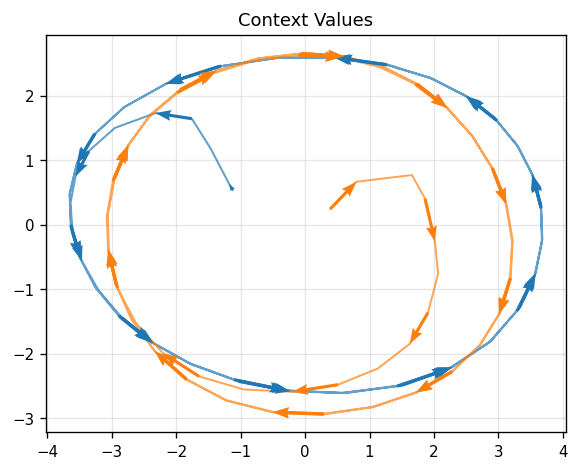

In [20]:
pca = PCA(n_components=2)

hs_a_pca = pca.fit_transform(hs_a)
hs_b_pca = pca.fit_transform(hs_b)

fig, ax = plt.subplots(figsize=(14, 4))
plot_with_arrows(ax, [hs_a_pca, hs_b_pca], title="Context Values")
plt.tight_layout()
plt.show()

## Experiment 4 — Intersecting circles

Circles with shifted centres share weights but get **separate learnable
$h_0$** vectors (`num_sequences=2`).  At the intersection the only thing
distinguishing the two dynamics is the latent initial state.

  epoch     1  loss 0.725777  |g| 2.4229
  epoch   500  loss 0.001288  |g| 0.0071
  epoch  1000  loss 0.000022  |g| 0.0007
  epoch  1500  loss 0.000005  |g| 0.0001
  epoch  2000  loss 0.000003  |g| 0.0000
  epoch  2500  loss 0.000002  |g| 0.0000
  epoch  3000  loss 0.000002  |g| 0.0005
  epoch  3500  loss 0.000016  |g| 0.0161
  epoch  4000  loss 0.000001  |g| 0.0002
  epoch  4500  loss 0.000001  |g| 0.0013
  epoch  5000  loss 0.000001  |g| 0.0006
  epoch  5500  loss 0.000008  |g| 0.0098
  epoch  6000  loss 0.000010  |g| 0.0114


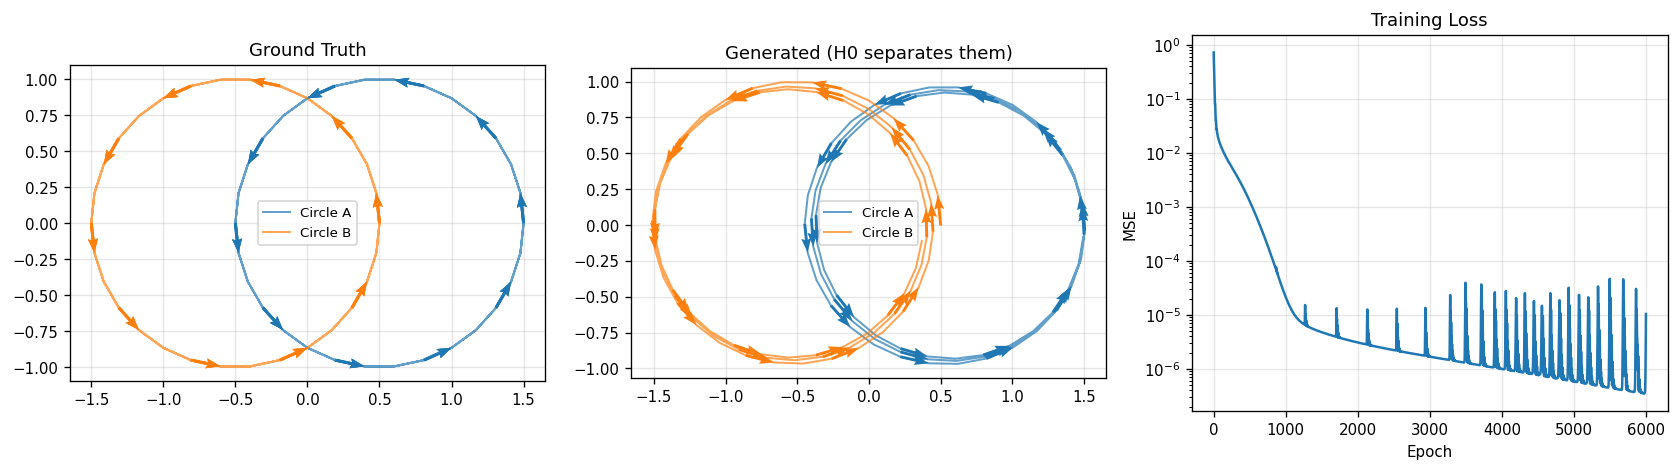

In [21]:
fn_a = lambda th: circle_curve(th, r=1.0, cx=0.5, cy=0.0)
fn_b = lambda th: circle_curve(th, r=1.0, cx=-0.5, cy=0.0)

xa, ya = make_sequences(fn_a, B, T, dt, rng)
xb, yb = make_sequences(fn_b, B, T, dt, rng)

x_train = np.concatenate([xa, xb], axis=1)
y_train = np.concatenate([ya, yb], axis=1)
batch_indices = np.array([0] * B + [1] * B, dtype=np.int64)

model = ElmanRNN(2, 64, 2, num_sequences=2, activation="tanh",
                   weight_scale=0.1, rng=2)
opt = Adam(lr=1e-3, clip_norm=1.0)

losses = train(model, opt, x_train, y_train, batch_indices, n_epochs=6000)

pred_a, hs_a = generate(model, np.array([1.5, 0.0]), n_steps=90, seq_idx=0)
pred_b, hs_b = generate(model, np.array([0.5, 0.0]), n_steps=90, seq_idx=1)

gt_theta = np.linspace(0, 6 * np.pi, 91)
gt_a = np.column_stack([np.cos(gt_theta) + 0.5, np.sin(gt_theta)])
gt_b = np.column_stack([np.cos(gt_theta) - 0.5, np.sin(gt_theta)])

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt_a, gt_b], title="Ground Truth",
                 labels=["Circle A", "Circle B"])
plot_with_arrows(axes[1], [pred_a, pred_b], title="Generated (H0 separates them)",
                 labels=["Circle A", "Circle B"])
axes[2].semilogy(losses)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

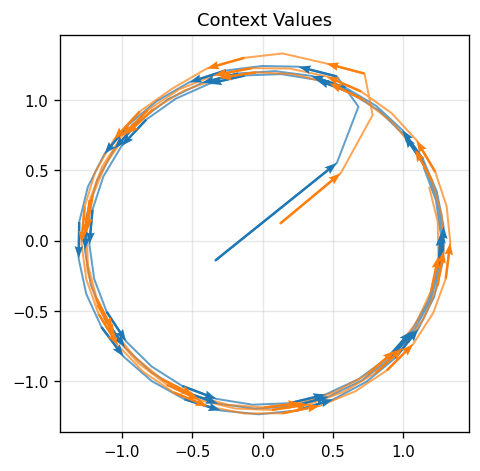

In [22]:
pca = PCA(n_components=2)

hs_a_pca = pca.fit_transform(hs_a)
hs_b_pca = pca.fit_transform(hs_b)

fig, ax = plt.subplots(figsize=(14, 4))
plot_with_arrows(ax, [hs_a_pca, hs_b_pca], title="Context Values")
plt.tight_layout()
plt.show()

  epoch     1  loss 8.747142  |g| 9.5346
  epoch   500  loss 0.004713  |g| 0.0235
  epoch  1000  loss 0.000685  |g| 0.0051
  epoch  1500  loss 0.000207  |g| 0.0017
  epoch  2000  loss 0.000087  |g| 0.0009
  epoch  2500  loss 0.000044  |g| 0.0014
  epoch  3000  loss 0.000023  |g| 0.0002
  epoch  3500  loss 0.000014  |g| 0.0093
  epoch  4000  loss 0.000007  |g| 0.0002
  epoch  4500  loss 0.000004  |g| 0.0005
  epoch  5000  loss 0.000016  |g| 0.0248
  epoch  5500  loss 0.000002  |g| 0.0016
  epoch  6000  loss 0.000002  |g| 0.0000
  epoch  6500  loss 0.000003  |g| 0.0077
  epoch  7000  loss 0.000003  |g| 0.0087
  epoch  7500  loss 0.000001  |g| 0.0000
  epoch  8000  loss 0.000001  |g| 0.0001


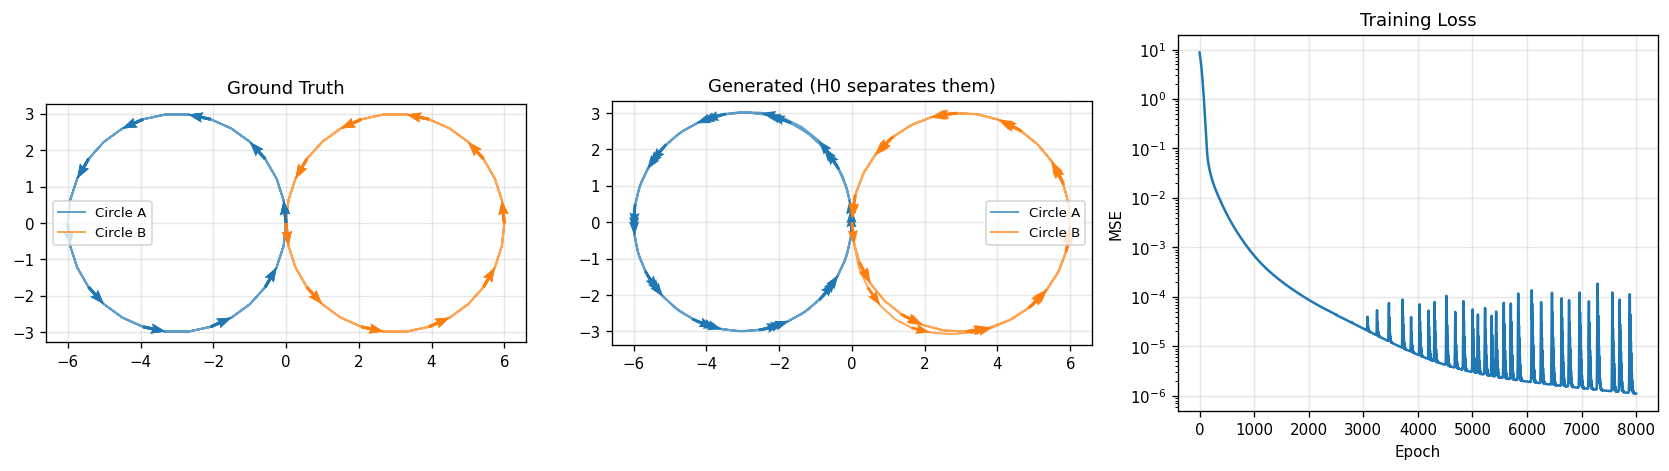

In [23]:
T, B_each = 30, 12
dt = 2 * np.pi / 30

fn_a = lambda th: circle_curve(th, r=3.0, cx=-3.0, cy=0.0)
fn_b = lambda th: circle_curve(th, r=3.0, cx=3.0, cy=0.0)

xa, ya = make_sequences(fn_a, B_each, T, dt, rng)
xb, yb = make_sequences(fn_b, B_each, T, dt, rng)

x_train2 = np.concatenate([xa, xb], axis=1) 
y_train2 = np.concatenate([ya, yb], axis=1)
batch_indices2 = np.array([0] * B_each + [1] * B_each, dtype=np.int64)

model_2 = ElmanRNN(2, 32, 2, num_sequences=2, activation="tanh",
                   weight_scale=0.1, rng=2)
opt_2 = Adam(lr=1e-3, clip_norm=1.0)

losses_2 = train(model_2, opt_2, x_train2, y_train2, batch_indices2, n_epochs=8000)

# Generate 3 cycles for each circle
pred_a, hs_a = generate(model_2, np.array([0.0, 0.0]), n_steps=90, seq_idx=0)
pred_b, hs_b = generate(model_2, np.array([0.0, 0.0]), n_steps=90, seq_idx=1)

gt_theta2 = np.linspace(0, 6 * np.pi, 91)
gt_a = np.column_stack(circle_curve(gt_theta2, r=3.0, cx=-3.0, cy=0.0))
gt_b = np.column_stack(circle_curve(gt_theta2, r=3.0, cx=3.0, cy=0.0))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt_a, gt_b], title="Ground Truth",
                 labels=["Circle A", "Circle B"])
plot_with_arrows(axes[1], [pred_a, pred_b], title="Generated (H0 separates them)",
                 labels=["Circle A", "Circle B"])
axes[2].semilogy(losses_2)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

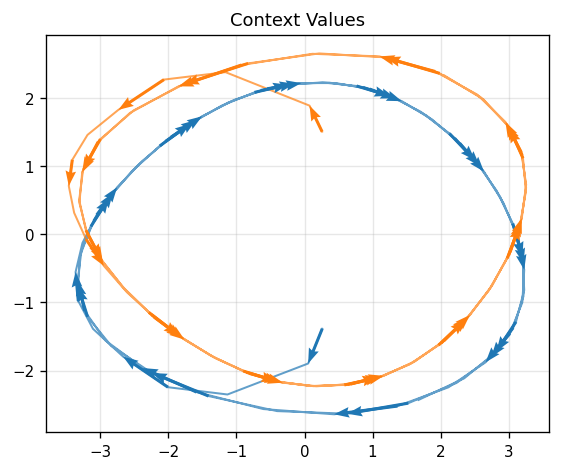

In [24]:
pca = PCA(n_components=2)

hs_a_pca = pca.fit_transform(hs_a)
hs_b_pca = pca.fit_transform(hs_b)

fig, ax = plt.subplots(figsize=(14, 4))
plot_with_arrows(ax, [hs_a_pca, hs_b_pca], title="Context Values")
plt.tight_layout()
plt.show()

  epoch     1  loss 8.296343  |g| 13.1288
  epoch   500  loss 0.001468  |g| 0.0159
  epoch  1000  loss 0.000523  |g| 0.0017
  epoch  1500  loss 0.000235  |g| 0.0010
  epoch  2000  loss 0.000166  |g| 0.0902
  epoch  2500  loss 0.000059  |g| 0.0017
  epoch  3000  loss 0.000040  |g| 0.0272
  epoch  3500  loss 0.000018  |g| 0.0049
  epoch  4000  loss 0.000012  |g| 0.0051
  epoch  4500  loss 0.000011  |g| 0.0133
  epoch  5000  loss 0.000006  |g| 0.0014
  epoch  5500  loss 0.000005  |g| 0.0014
  epoch  6000  loss 0.000008  |g| 0.0159


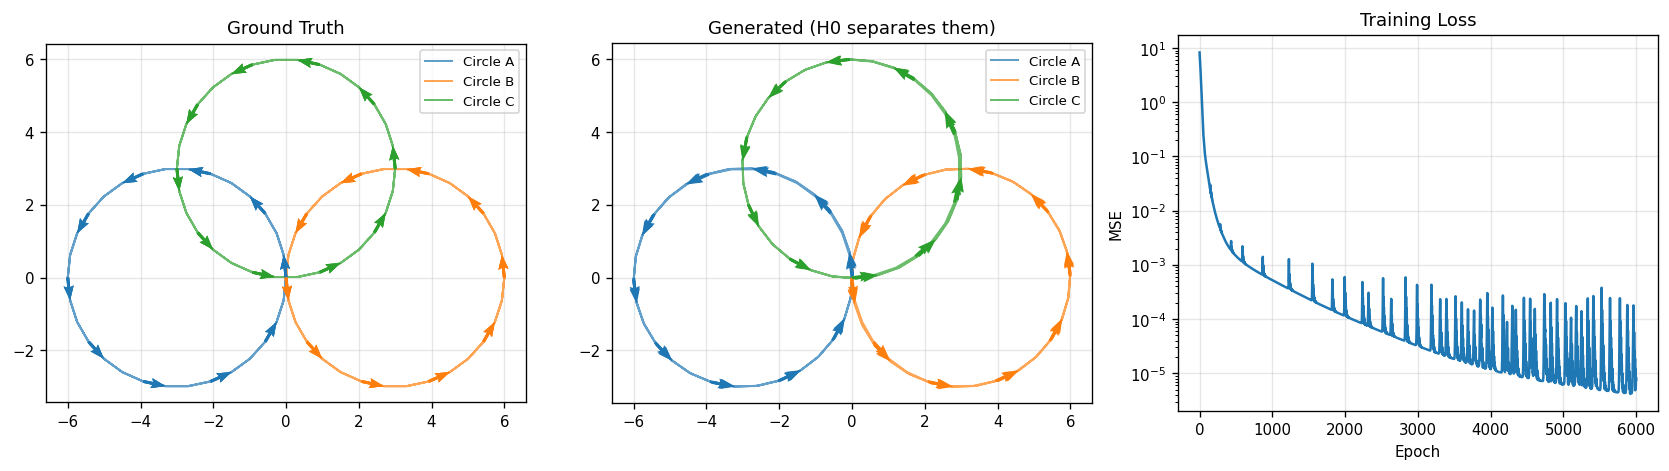

In [25]:
T, B_each = 30, 12
dt = 2 * np.pi / 30

fn_a = lambda th: circle_curve(th, r=3.0, cx=-3.0, cy=0.0)
fn_b = lambda th: circle_curve(th, r=3.0, cx=3.0, cy=0.0)
fn_c = lambda th: circle_curve(th, r=3.0, cx=0.0, cy=3.0)

xa, ya = make_sequences(fn_a, B_each, T, dt, rng)
xb, yb = make_sequences(fn_b, B_each, T, dt, rng)
xc, yc = make_sequences(fn_c, B_each, T, dt, rng)

x_train = np.concatenate([xa, xb, xc], axis=1)
y_train = np.concatenate([ya, yb, yc], axis=1)
batch_indices = np.array([0] * B_each + [1] * B_each + [2] * B_each, dtype=np.int64)

model = ElmanRNN(2, 64, 2, num_sequences=3, activation="tanh",
                   weight_scale=0.1, rng=rng)
opt = Adam(lr=1e-3, clip_norm=1.0)

losses = train(model, opt, x_train, y_train, batch_indices, n_epochs=6000)

pred_a, hs_a = generate(model, np.array([0.0, 0.0]), n_steps=90, seq_idx=0)
pred_b, hs_b = generate(model, np.array([0.0, 0.0]), n_steps=90, seq_idx=1)
pred_c, hs_c = generate(model, np.array([0.0, 0.0]), n_steps=90, seq_idx=2)

gt_theta = np.linspace(0, 6 * np.pi, 91)
gt_a = np.column_stack(circle_curve(gt_theta, r=3.0, cx=-3.0, cy=0.0))
gt_b = np.column_stack(circle_curve(gt_theta, r=3.0, cx=3.0, cy=0.0))
gt_c = np.column_stack(circle_curve(gt_theta, r=3.0, cx=0.0, cy=3.0))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt_a, gt_b, gt_c], title="Ground Truth",
                 labels=["Circle A", "Circle B", "Circle C"])
plot_with_arrows(axes[1], [pred_a, pred_b, pred_c], title="Generated (H0 separates them)",
                 labels=["Circle A", "Circle B", "Circle C"])
axes[2].semilogy(losses)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

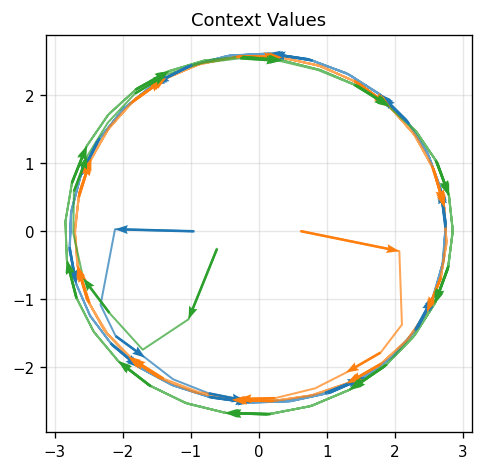

In [26]:
pca = PCA(n_components=2)

hs_a_pca = pca.fit_transform(hs_a)
hs_b_pca = pca.fit_transform(hs_b)
hs_c_pca = pca.fit_transform(hs_c)

fig, ax = plt.subplots(figsize=(14, 4))
plot_with_arrows(ax, [hs_a_pca, hs_b_pca, hs_c_pca], title="Context Values")
plt.tight_layout()
plt.show()